# Part 1 — Word Embeddings and Analysis (TREC)

This notebook prepares pretrained Word2Vec embeddings for the TREC dataset, reports vocabulary and OOV statistics, implements an OOV mitigation strategy, constructs an embedding matrix, and visualizes top tokens per topic using dimensionality reduction.

Notes:
- Uses `gensim` Word2Vec (`word2vec-google-news-300`). The download is large (~1.6GB). Run in Google Colab for sufficient bandwidth/storage.
- Tokenization uses spaCy `en_core_web_sm`.
- Input files expected: `trec_train.csv`, `trec_val.csv`, `trec_test.csv` (from Part 0). If not found locally, you can upload them interactively in Colab.


In [20]:
# If running on Colab, install dependencies
import sys, subprocess, os
!pip -q install gensim spacy pandas scikit-learn matplotlib tqdm
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------- ------------------------------ 3.1/12.8 MB 15.3 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 12.1 MB/s eta 0:00:01
     ---------------------- ----------------- 7.3/12.8 MB 11.6 MB/s eta 0:00:01
     --------------------------- ------------ 8.9/12.8 MB 10.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 10.1 MB/s eta 0:00:01
     ------------------------------------- -- 12.1/12.8 MB 9.7 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
# Imports and paths
import pandas as pd
import numpy as np
import spacy
from collections import Counter, defaultdict
from pathlib import Path

ROOT = Path().resolve().parent
DATA = ROOT / "notebooks" / "data"

train_df = pd.read_csv(DATA / "trec_train.csv")
val_df   = pd.read_csv(DATA / "trec_val.csv")
test_df  = pd.read_csv(DATA / "trec_test.csv")

print(train_df.shape, val_df.shape, test_df.shape)


(4362, 2) (1090, 2) (500, 2)


## Q1(a) — Tokenization and Vocabulary Size
We tokenize the training set with spaCy (`en_core_web_sm`), lowercase tokens, and build the training vocabulary.
- Output to record in report: `Vocabulary size` printed below.
- Note: Special tokens `<pad>` and `<unk>` are included; counts reported reflect total unique tokens including these.


In [7]:
# Tokenization and frequency stats
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])

def tokenize(text: str):
    doc = nlp(str(text))
    return [t.text.lower() for t in doc if not t.is_space]

# Build token frequency from TRAIN only
token_freq = Counter()
label_token_freq = defaultdict(Counter)

for text, label in zip(train_df["text"], train_df["label"]):
    toks = tokenize(text)
    token_freq.update(toks)
    label_token_freq[label].update(toks)

# Vocab with PAD=0, UNK=1
PAD_IDX, UNK_IDX = 0, 1
itos = ["<pad>", "<unk>"] + [w for w, _ in token_freq.items()]
stoi = {w: i for i, w in enumerate(itos)}
VOCAB_SIZE = len(itos)

print("Vocabulary size:", VOCAB_SIZE)


Vocabulary size: 7435


In [9]:
# Load Word2Vec (GoogleNews 300d) via gensim
import gensim.downloader as api

print("hey")
MODEL_NAME = "word2vec-google-news-300"  # ~1.6GB
print("Loading pretrained:", MODEL_NAME)
vectors = api.load(MODEL_NAME)  # may take a while on first run
EMBED_DIM = vectors.vector_size
print("Embedding dim:", EMBED_DIM, "| Vocab size in model:", len(vectors.key_to_index))


hey
Loading pretrained: word2vec-google-news-300
Embedding dim: 300 | Vocab size in model: 3000000


## Q1(b) — OOV Counts Overall and Per Topic
We load Word2Vec (GoogleNews 300d) and compare its vocabulary to our training vocabulary:
- `unique_oov`: training-vocab tokens missing from Word2Vec (the OOV words).
- `unique_iv`: training-vocab tokens present in Word2Vec.
- Printed metrics: counts of both and overall OOV rate.
- `per_label_unique_oov`: number of unique OOV words per topic (based on tokens observed in that topic in the training set).
Record these values in the report.


In [11]:
# OOV statistics (unique-token based)
pretrained_vocab = set(vectors.key_to_index.keys())

vocab_words = set(itos[2:])  # exclude pad/unk
unique_oov = sorted([w for w in vocab_words if w not in pretrained_vocab])
unique_iv  = sorted([w for w in vocab_words if w in pretrained_vocab])

print("Unique IV tokens:", len(unique_iv))
print("Unique OOV tokens:", len(unique_oov))
print("OOV rate (%):", round(100 * len(unique_oov) / max(1, len(vocab_words)), 2))

# Per-topic unique OOV counts
per_label_unique_oov = {}
for label, cnts in label_token_freq.items():
    words = set(cnts.keys())
    per_label_unique_oov[label] = len([w for w in words if w not in pretrained_vocab])

per_label_unique_oov


Unique IV tokens: 6357
Unique OOV tokens: 1076
OOV rate (%): 14.48


{'HUM': 349, 'DESC': 198, 'ENTY': 337, 'LOC': 222, 'NUM': 177, 'ABBR': 31}

## Q1(c) — OOV Mitigation Strategy and Embedding Matrix
We mitigate OOV by:
- Lowercasing lookup.
- Splitting tokens on non-alphanumerics (e.g., hyphens) and averaging vectors of known parts.
- Falling back to the mean vector of known training-vocab embeddings if still OOV.
We then construct the embedding matrix (PAD=0, UNK=mean), saving it for Part 2. Include the code snippet and describe the rationale in the report.


## Q1(d) — 2D Projection of Top-20 Words per Topic
We select the 20 most frequent tokens per topic (with optional stopword removal), retrieve embeddings using the same OOV logic, project to 2D via PCA, and plot a color-coded scatter.
- Output: `part1_pca_top20_per_topic.png` saved to `notebooks/data`.
- What to expect: partial clustering by topic; overlaps for generic terms; OOV-handled tokens may sit closer to the global mean.
Briefly interpret the plot in the report.


In [ ]:
# OOV mitigation strategy and embedding matrix construction
import re
import pickle

# Compute mean vector of known tokens to initialize UNK or OOV
known_vecs = []
for w in unique_iv:
    try:
        known_vecs.append(vectors[w])
    except KeyError:
        pass
KNOWN_MEAN = np.mean(known_vecs, axis=0) if len(known_vecs) else np.zeros(EMBED_DIM, dtype=np.float32)

split_pattern = re.compile(r"[^a-z0-9]+")

def get_token_vector(token: str) -> np.ndarray:
    token = token.lower()
    if token in vectors:
        return vectors[token]
    parts = [p for p in split_pattern.split(token) if p]
    part_vecs = [vectors[p] for p in parts if p in vectors]
    if part_vecs:
        return np.mean(part_vecs, axis=0)
    return KNOWN_MEAN

# Build embedding matrix [VOCAB_SIZE, EMBED_DIM]
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM), dtype=np.float32)
embedding_matrix[PAD_IDX] = np.zeros(EMBED_DIM, dtype=np.float32)
embedding_matrix[UNK_IDX] = KNOWN_MEAN

for w, i in stoi.items():
    if i < 2:
        continue
    embedding_matrix[i] = get_token_vector(w)

print("Embedding matrix:", embedding_matrix.shape)

# Optionally save for Part 2
EMB_OUT = ROOT / "notebooks" / "data" / f"w2v_{EMBED_DIM}d_embedding_matrix.npy"
EMB_OUT.parent.mkdir(parents=True, exist_ok=True)
np.save(EMB_OUT, embedding_matrix)
print("Saved:", EMB_OUT)

VOCAB_OUT = ROOT / "notebooks" / "data" / "vocab.pkl"
VOCAB_OUT.parent.mkdir(parents=True, exist_ok=True)
with open (VOCAB_OUT, 'wb') as f:
    pickle.dump({'stoi':stoi,'itos':itos}, f)
print("Saved:", VOCAB_OUT)

Embedding matrix: (7435, 300)
Saved: C:\Users\7430\Desktop\NTU-projects\nlp-assignment\notebooks\data\w2v_300d_embedding_matrix.npy


Saved plot: C:\Users\7430\Desktop\NTU-projects\nlp-assignment\notebooks\data\part1_pca_top20_per_topic.png


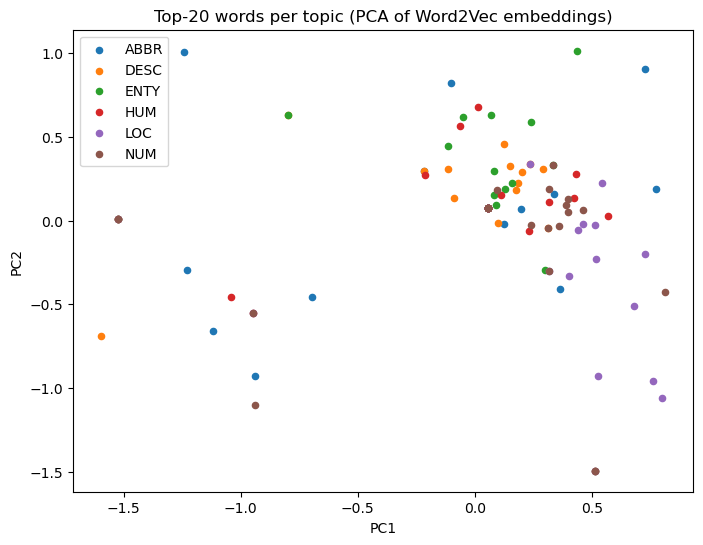

In [17]:
# Visualization: Top-20 tokens per label and PCA scatter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Build stopword set from spaCy
stopwords = {lex.text for lex in nlp.vocab if lex.is_stop}

def top_k_tokens_per_label(k=20, remove_stop=True):
    selected = []
    for label, cnts in label_token_freq.items():
        items = list(cnts.items())
        items.sort(key=lambda x: -x[1])
        words = [w for w, _ in items]
        if remove_stop:
            words = [w for w in words if w not in stopwords]
        selected.extend([(w, label) for w in words[:k]])
    return selected


pairs = top_k_tokens_per_label(20, remove_stop=True)
points = []
colors = []
texts = []

for w, lab in pairs:
    vec = get_token_vector(w)
    points.append(vec)
    colors.append(lab)
    texts.append(w)

X = np.stack(points)
X2 = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(8,6))
labels_set = sorted(set(colors))
for lab in labels_set:
    idx = [i for i, c in enumerate(colors) if c == lab]
    plt.scatter(X2[idx,0], X2[idx,1], s=20, label=lab)
plt.legend()
plt.title("Top-20 words per topic (PCA of Word2Vec embeddings)")
plt.xlabel("PC1")
plt.ylabel("PC2")

PLOT_OUT = ROOT / "notebooks" / "data" / "part1_pca_top20_per_topic.png"
plt.savefig(PLOT_OUT, dpi=150, bbox_inches='tight')
print("Saved plot:", PLOT_OUT)
plt.show()
